In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

# PREPARING THE DATA

In [2]:
df = pd.read_csv("BTC_USD_2014-11-04_2021-12-03-CoinDesk.csv",
                 parse_dates = ["Date"],
                 index_col = ["Date"])
df

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2014-11-04,BTC,324.467934,323.826186,333.539527,323.106623
2014-11-05,BTC,328.644408,324.424164,330.671610,320.902900
2014-11-06,BTC,337.921358,328.653046,342.384170,328.597125
2014-11-07,BTC,348.992860,337.921358,352.585895,336.236830
2014-11-08,BTC,341.459753,348.992860,351.651854,340.196145
...,...,...,...,...,...
2021-11-29,BTC,57303.185972,54784.900000,57461.551028,53359.800000
2021-11-30,BTC,57834.357549,57305.932502,58890.733509,56770.710000
2021-12-01,BTC,56973.182042,57834.367211,59223.380063,55948.430857


In [5]:
df_cp = pd.DataFrame(df["Closing Price (USD)"]).rename(columns = {"Closing Price (USD)":"Price"})
df_cp

,Price
Date,
2014-11-04,324.467934
2014-11-05,328.644408
2014-11-06,337.921358
2014-11-07,348.992860
2014-11-08,341.459753
...,...
2021-11-29,57303.185972
2021-11-30,57834.357549
2021-12-01,56973.182042


In [11]:
window_size = 7
horizon_size = 1
df_cp_win = df_cp.copy()
for i in range(window_size):
    df_cp_win[f"Price + {i+1}"] = df_cp["Price"].shift(periods = i+1)
df_cp_win.head(10)

,Price,Price + 1,Price + 2,Price + 3,Price + 4,Price + 5,Price + 6,Price + 7
Date,,,,,,,,
2014-11-04,324.467934,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-11-05,328.644408,324.467934,NaN,NaN,NaN,NaN,NaN,NaN
2014-11-06,337.921358,328.644408,324.467934,NaN,NaN,NaN,NaN,NaN
2014-11-07,348.992860,337.921358,328.644408,324.467934,NaN,NaN,NaN,NaN
2014-11-08,341.459753,348.992860,337.921358,328.644408,324.467934,NaN,NaN,NaN
2014-11-09,344.745289,341.459753,348.992860,337.921358,328.644408,324.467934,NaN,NaN
2014-11-10,357.239982,344.745289,341.459753,348.992860,337.921358,328.644408,324.467934,NaN
2014-11-11,371.116917,357.239982,344.745289,341.459753,348.992860,337.921358,328.644408,324.467934
2014-11-12,366.664633,371.116917,357.239982,344.745289,341.459753,348.992860,337.921358,328.644408


In [66]:
df_features = df_cp_win.dropna().drop("Price", axis = 1).to_numpy()
df_labels = df_cp_win.dropna()["Price"]
len(df_features),len(df_labels)

(2580, 2580)

In [67]:
x = df_features
y = df_labels

In [21]:
df_features = tf.data.Dataset.from_tensor_slices(x)
df_labels = tf.data.Dataset.from_tensor_slices(y)

In [22]:
df_train = tf.data.Dataset.zip((df_features, df_labels))
df_train = df_train.batch(128).prefetch(tf.data.AUTOTUNE)
df_train

<PrefetchDataset shapes: ((None, 7), (None,)), types: (tf.float64, tf.float64)>

# BUILDING THE FUTURE PREDICTION MODEL

![](future_preds_diagram.PNG)

In [25]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(1,activation="linear")
])
model.compile(loss = "mae", optimizer = tf.keras.optimizers.Adam(), metrics = ["mae", "mse"])
history = model.fit(df_train, epochs = 1000, verbose = 0)

In [27]:
model.evaluate(df_train)

21/21 [==============================] - 0s 3ms/step - loss: 326.2764 - mae: 326.2764 - mse: 574947.3750


[326.2763977050781, 326.2763977050781, 574947.375]

In [53]:
days = 14
def future_preds(window_size = 7,
                 model = model,
                 days = days,
                 values = y):
    final_preds = []
    last_window = list(values[-window_size:])
    for i in range(days):
        preds = model.predict(tf.expand_dims(last_window,axis=0))
        final_preds.append(tf.squeeze(preds).numpy())
        last_window.append(tf.squeeze(preds).numpy())
        last_window = last_window[-window_size:]
    return final_preds

In [55]:
final_preds = future_preds()

# PLOTTING THE PREDICTIONS 

In [68]:
timesteps = y.index.to_numpy()
timesteps

array(['2014-11-11T00:00:00.000000000', '2014-11-12T00:00:00.000000000',
       '2014-11-13T00:00:00.000000000', ...,
       '2021-12-01T00:00:00.000000000', '2021-12-02T00:00:00.000000000',
       '2021-12-03T00:00:00.000000000'], dtype='datetime64[ns]')

In [74]:
def extend_dates(start,days,offset=1):
    start = start + np.timedelta64(offset, "D")
    end = start + np.timedelta64(days, "D")
    return np.arange(start,end,dtype="datetime64[D]")

In [78]:
next_timesteps = extend_dates(timesteps[-1], 14)
next_timesteps = np.insert(next_timesteps, 0, timesteps[-1])
forecast = np.insert(final_preds,0,y[-1])
next_timesteps, forecast

(array(['2021-12-03', '2021-12-04', '2021-12-05', '2021-12-06',
        '2021-12-07', '2021-12-08', '2021-12-09', '2021-12-10',
        '2021-12-11', '2021-12-12', '2021-12-13', '2021-12-14',
        '2021-12-15', '2021-12-16', '2021-12-17'], dtype='datetime64[D]'),
 array([56524.83 , 54183.457, 55493.004, 57513.836, 57465.59 , 56667.547,
        57069.754, 56363.816, 54619.355, 56026.72 , 57566.21 , 57113.   ,
        56492.82 , 56982.215, 56277.223], dtype=float32))

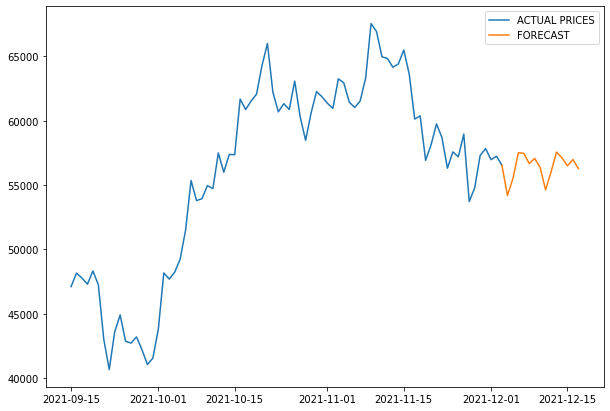

In [83]:
plt.figure(figsize=(10,7))
plt.plot(timesteps[2500:],y[2500:], label = "ACTUAL PRICES")
plt.plot(next_timesteps, forecast, label = "FORECAST")
plt.legend()